#Assignment 1 : Introduction to Deep learning by Ninad Sharma and Evelyn Starzew

In [2]:
import tensorflow as tf

In [3]:
tf.Tensor

tensorflow.python.framework.ops.Tensor

In [4]:
print(tf.math.add(1, 2))
print(tf.math.add([1, 2], [3, 4]))
print(tf.math.square(5))
print(tf.math.reduce_sum([1, 2, 3]))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)


In [5]:
import numpy as np

ndarray = np.ones([3, 3])

print("TensorFlow operations convert numpy arrays to Tensors automatically")
tensor = tf.math.multiply(ndarray, 42)
print(tensor)


print("And NumPy operations convert Tensors to NumPy arrays automatically")
print(np.add(tensor, 1))

print("The .numpy() method explicitly converts a Tensor to a numpy array")
print(tensor.numpy())

TensorFlow operations convert numpy arrays to Tensors automatically
tf.Tensor(
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]], shape=(3, 3), dtype=float64)
And NumPy operations convert Tensors to NumPy arrays automatically
[[43. 43. 43.]
 [43. 43. 43.]
 [43. 43. 43.]]
The .numpy() method explicitly converts a Tensor to a numpy array
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]]


In [6]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.config.list_physical_devices("GPU"))

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[]
Is the Tensor on GPU #0:  
False


In [7]:
ds_tensors = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6])

# Create a CSV file
import tempfile
_, filename = tempfile.mkstemp()

with open(filename, 'w') as f:
  f.write("""Line 1
Line 2
Line 3
  """)

ds_file = tf.data.TextLineDataset(filename)

In [8]:
print(ds_file.batch(1))

<_BatchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>


In [9]:
ds_tensors = ds_tensors.map(tf.math.square).shuffle(2).batch(2)

ds_file = ds_file.batch(2)

In [10]:
print('Elements of ds_tensors:')
for x in ds_tensors:
  print(x)

print('\nElements in ds_file:')
for x in ds_file:
  print(x)

Elements of ds_tensors:
tf.Tensor([4 1], shape=(2,), dtype=int32)
tf.Tensor([ 9 16], shape=(2,), dtype=int32)
tf.Tensor([36 25], shape=(2,), dtype=int32)

Elements in ds_file:
tf.Tensor([b'Line 1' b'Line 2'], shape=(2,), dtype=string)
tf.Tensor([b'Line 3' b'  '], shape=(2,), dtype=string)


MNIST Linear Model

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import MNISTDataset
import ssl

#Issue with downloading dataset in mac : https://github.com/tensorflow/tensorflow/issues/33285

In [12]:
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [13]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


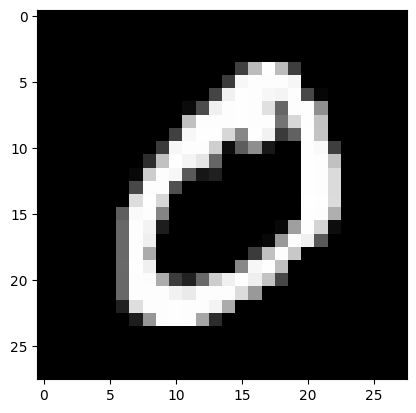

In [14]:
plt.imshow(train_images[1], cmap="Greys_r")

In [15]:
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

In [16]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


#Single Linear Model

In [17]:
train_steps = 1000
learning_rate = 0.1

W = tf.Variable(np.zeros([784, 10]).astype(np.float32))
b = tf.Variable(np.zeros(10, dtype=np.float32))


In [18]:
for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:
        logits = tf.matmul(img_batch, W) + b
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))
        
    grads = tape.gradient(xent, [W, b])
    W.assign_sub(learning_rate * grads[0])
    b.assign_sub(learning_rate * grads[1])
    
    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

Loss: 2.3025853633880615 Accuracy: 0.09375
Loss: 0.5894189476966858 Accuracy: 0.875
Loss: 0.4529939293861389 Accuracy: 0.8671875
Loss: 0.4487823247909546 Accuracy: 0.890625
Loss: 0.4969169497489929 Accuracy: 0.8671875
Starting new epoch...
Loss: 0.32988351583480835 Accuracy: 0.9140625
Loss: 0.4170212149620056 Accuracy: 0.8828125
Loss: 0.4647836685180664 Accuracy: 0.8671875
Loss: 0.2882106900215149 Accuracy: 0.8984375
Loss: 0.2747473418712616 Accuracy: 0.9140625
Starting new epoch...


In [19]:
test_preds = tf.argmax(tf.matmul(data.test_data, W) + b, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)

tf.Tensor(0.9091, shape=(), dtype=float32)


#Trying bias and weight with random number rather than 0.

In [20]:
train_steps = 1000
learning_rate = 0.1

W = tf.Variable(initial_value=np.random.rand(784, 10), dtype= tf.float32)
b = tf.Variable(initial_value=np.random.rand(1, 10), dtype = tf.float32)

In [21]:
print(np.random.rand(784, 10)[0])

[0.7226083  0.99872598 0.36603685 0.88121572 0.56589119 0.86813585
 0.1338251  0.47629079 0.53529023 0.60967511]


In [22]:
for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:
        logits = tf.matmul(img_batch, W) + b
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))
        
    grads = tape.gradient(xent, [W, b])
    W.assign_sub(learning_rate * grads[0])
    b.assign_sub(learning_rate * grads[1])
    
    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

Loss: 4.0224690437316895 Accuracy: 0.140625
Loss: 0.8523151278495789 Accuracy: 0.7578125
Loss: 0.6827248930931091 Accuracy: 0.8046875
Loss: 0.5546939373016357 Accuracy: 0.8203125
Loss: 0.6821498274803162 Accuracy: 0.8046875
Starting new epoch...
Loss: 0.4488903284072876 Accuracy: 0.84375
Loss: 0.4948389232158661 Accuracy: 0.859375
Loss: 0.5617841482162476 Accuracy: 0.8125
Loss: 0.4252125918865204 Accuracy: 0.84375
Starting new epoch...
Loss: 0.4254511892795563 Accuracy: 0.8828125


In [23]:
test_preds = tf.argmax(tf.matmul(data.test_data, W) + b, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)

tf.Tensor(0.8891, shape=(), dtype=float32)


#Not much diff in case of single layer

#Multi layer Neural network - (3 hidden layer)

In [24]:

# Define the number of hidden units for each layer
hidden_units = [256, 128, 64]

#Training step same as single layer
train_steps = 1000
learning_rate = 0.1

W_input = tf.Variable(np.zeros([784, hidden_units[0]]).astype(np.float32))
b_input = tf.Variable(np.zeros(hidden_units[0], dtype=np.float32))

# Weight and bias variables for the first hidden layer
W_hidden1 = tf.Variable(np.zeros([hidden_units[0], hidden_units[1]]).astype(np.float32))
b_hidden1 = tf.Variable(np.zeros(hidden_units[1], dtype=np.float32))

# Weight and bias variables for the second hidden layer
W_hidden2 = tf.Variable(np.zeros([hidden_units[1], hidden_units[2]]).astype(np.float32))
b_hidden2 = tf.Variable(np.zeros(hidden_units[2], dtype=np.float32))

# Weight and bias variables for the output layer
W_output = tf.Variable(np.zeros([hidden_units[2], 10]).astype(np.float32))
b_output = tf.Variable(np.zeros(10, dtype=np.float32))

In [25]:
for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:
        # Forward pass
        hidden1 = tf.nn.relu(tf.matmul(img_batch, W_input) + b_input)
        hidden2 = tf.nn.relu(tf.matmul(hidden1, W_hidden1) + b_hidden1)
        hidden3 = tf.nn.relu(tf.matmul(hidden2, W_hidden2) + b_hidden2)
        logits = tf.matmul(hidden3, W_output) + b_output

        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))

    grads = tape.gradient(xent, [W_input, b_input, W_hidden1, b_hidden1, W_hidden2, b_hidden2, W_output, b_output])
    W_input.assign_sub(learning_rate * grads[0])
    b_input.assign_sub(learning_rate * grads[1])
    W_hidden1.assign_sub(learning_rate * grads[2])
    b_hidden1.assign_sub(learning_rate * grads[3])
    W_hidden2.assign_sub(learning_rate * grads[4])
    b_hidden2.assign_sub(learning_rate * grads[5])
    W_output.assign_sub(learning_rate * grads[6])
    b_output.assign_sub(learning_rate * grads[7])

    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

# test_preds = tf.argmax(tf.matmul(data.test_data, W_output) + b_output, axis=1, output_type=tf.int32)
# acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels), tf.float32))
# print(acc)


Loss: 2.3025853633880615 Accuracy: 0.1171875
Loss: 2.2971901893615723 Accuracy: 0.15625
Loss: 2.3076767921447754 Accuracy: 0.0703125
Loss: 2.3022665977478027 Accuracy: 0.1171875
Starting new epoch...
Loss: 2.295161247253418 Accuracy: 0.1796875
Loss: 2.2932353019714355 Accuracy: 0.140625
Loss: 2.3061938285827637 Accuracy: 0.1015625
Loss: 2.296821355819702 Accuracy: 0.1328125
Loss: 2.306473970413208 Accuracy: 0.1328125
Starting new epoch...
Loss: 2.2958948612213135 Accuracy: 0.125


#Low accuracy if we take weights and bias as zeroes - issues of Symmetry,Vanishing Gradients:

#Trying with random weights and bias. 

In [26]:
# Function to initialize weights with random values in the range [-0.1, 0.1]
def initialize_weights(shape):
    return tf.Variable(np.random.uniform(low=-0.1, high=0.1, size=shape).astype(np.float32))

# Function to initialize biases with random values in the range [-0.1, 0.1]
def initialize_biases(shape):
    return tf.Variable(np.random.uniform(low=-0.1, high=0.1, size=shape).astype(np.float32))


In [27]:
hidden_units = [256, 128, 784]
# Initialize weights and biases
W_input = initialize_weights([784, hidden_units[0]])
b_input = initialize_biases([hidden_units[0]])
W_hidden1 = initialize_weights([hidden_units[0], hidden_units[1]])
b_hidden1 = initialize_biases([hidden_units[1]])
W_hidden2 = initialize_weights([hidden_units[1], hidden_units[2]])
b_hidden2 = initialize_biases([hidden_units[2]])
W_output = initialize_weights([hidden_units[2], 10])
b_output = initialize_biases([10])

for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:
        # Forward pass
        hidden1 = tf.nn.relu(tf.matmul(img_batch, W_input) + b_input)
        hidden2 = tf.nn.relu(tf.matmul(hidden1, W_hidden1) + b_hidden1)
        hidden3 = tf.nn.relu(tf.matmul(hidden2, W_hidden2) + b_hidden2)
        logits = tf.matmul(hidden3, W_output) + b_output

        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))

    grads = tape.gradient(xent, [W_input, b_input, W_hidden1, b_hidden1, W_hidden2, b_hidden2, W_output, b_output])
    
    # Update weights and biases
    W_input.assign_sub(learning_rate * grads[0])
    b_input.assign_sub(learning_rate * grads[1])
    W_hidden1.assign_sub(learning_rate * grads[2])
    b_hidden1.assign_sub(learning_rate * grads[3])
    W_hidden2.assign_sub(learning_rate * grads[4])
    b_hidden2.assign_sub(learning_rate * grads[5])
    W_output.assign_sub(learning_rate * grads[6])
    b_output.assign_sub(learning_rate * grads[7])

    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))
test_preds = tf.argmax(tf.matmul(data.test_data, W_output) + b_output, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels), tf.float32))
print("Accuracy",acc)
#print(grads)

Loss: 2.291621685028076 Accuracy: 0.125
Loss: 0.36272144317626953 Accuracy: 0.90625
Loss: 0.45384442806243896 Accuracy: 0.8515625
Starting new epoch...
Loss: 0.33638250827789307 Accuracy: 0.90625
Loss: 0.18593023717403412 Accuracy: 0.9453125
Loss: 0.21750099956989288 Accuracy: 0.9296875
Loss: 0.2133113145828247 Accuracy: 0.9140625
Loss: 0.17549805343151093 Accuracy: 0.9609375
Starting new epoch...
Loss: 0.14238759875297546 Accuracy: 0.953125
Loss: 0.08295886218547821 Accuracy: 0.9765625
Accuracy tf.Tensor(0.0954, shape=(), dtype=float32)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

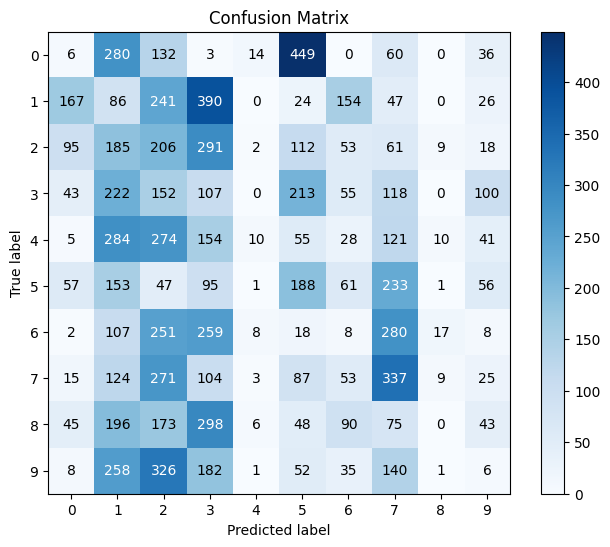

In [28]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    data.test_labels, 
    test_preds,
    figsize=(8,6))

#This shows that initializing weights with 0 does not work.

In [29]:
hidden_units = [256, 128, 64, 784]  # Adding one more hidden layer

# Initialize weights and biases for all layers
W_input = initialize_weights([784, hidden_units[0]])
b_input = initialize_biases([hidden_units[0]])

W_hidden1 = initialize_weights([hidden_units[0], hidden_units[1]])
b_hidden1 = initialize_biases([hidden_units[1]])

W_hidden2 = initialize_weights([hidden_units[1], hidden_units[2]])
b_hidden2 = initialize_biases([hidden_units[2]])

# New hidden layer
W_hidden3 = initialize_weights([hidden_units[2], hidden_units[3]])
b_hidden3 = initialize_biases([hidden_units[3]])

W_output = initialize_weights([hidden_units[3], 10])
b_output = initialize_biases([10])

for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:
        # Forward pass
        hidden1 = tf.nn.relu(tf.matmul(img_batch, W_input) + b_input)
        hidden2 = tf.nn.relu(tf.matmul(hidden1, W_hidden1) + b_hidden1)
        hidden3 = tf.nn.relu(tf.matmul(hidden2, W_hidden2) + b_hidden2)

        # New hidden layer
        hidden4 = tf.nn.relu(tf.matmul(hidden3, W_hidden3) + b_hidden3)

        logits = tf.matmul(hidden4, W_output) + b_output

        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))

    grads = tape.gradient(xent, [W_input, b_input, W_hidden1, b_hidden1, W_hidden2, b_hidden2,
                                  W_hidden3, b_hidden3, W_output, b_output])

    # Update weights and biases
    W_input.assign_sub(learning_rate * grads[0])
    b_input.assign_sub(learning_rate * grads[1])
    W_hidden1.assign_sub(learning_rate * grads[2])
    b_hidden1.assign_sub(learning_rate * grads[3])
    W_hidden2.assign_sub(learning_rate * grads[4])
    b_hidden2.assign_sub(learning_rate * grads[5])

    # New layer
    W_hidden3.assign_sub(learning_rate * grads[6])
    b_hidden3.assign_sub(learning_rate * grads[7])

    W_output.assign_sub(learning_rate * grads[8])
    b_output.assign_sub(learning_rate * grads[9])

    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))
test_preds = tf.argmax(tf.matmul(data.test_data, W_output) + b_output, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels), tf.float32))
print(acc)
#print(grads)

Loss: 2.3176159858703613 Accuracy: 0.125
Loss: 0.7382217645645142 Accuracy: 0.7890625
Loss: 0.4928053021430969 Accuracy: 0.8125
Starting new epoch...
Loss: 0.31023117899894714 Accuracy: 0.90625
Loss: 0.363361656665802 Accuracy: 0.8984375
Loss: 0.17198680341243744 Accuracy: 0.9453125
Loss: 0.27017679810523987 Accuracy: 0.9375
Starting new epoch...
Loss: 0.19855445623397827 Accuracy: 0.953125
Loss: 0.10669077187776566 Accuracy: 0.96875
Loss: 0.1006411761045456 Accuracy: 0.953125
tf.Tensor(0.1057, shape=(), dtype=float32)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

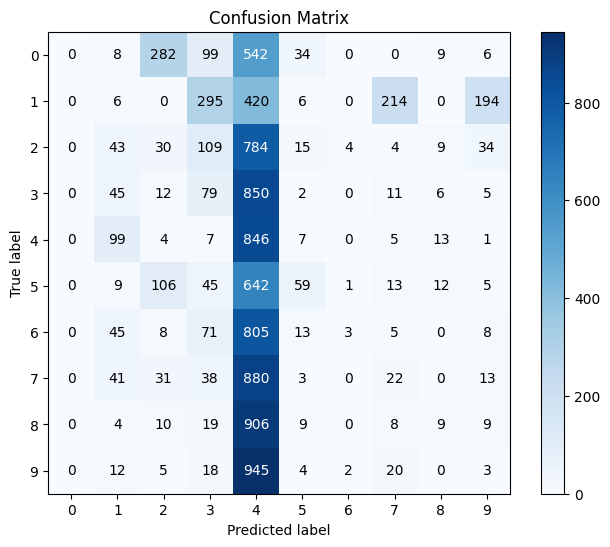

In [30]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    data.test_labels, 
    test_preds,
    figsize=(8,6))

#Trying with sigmoid activation function : We see that accuracy decreases for sigmoid in this case. Why?

In [31]:

hidden_units = [256, 128, 64, 784]  # Adding one more hidden layer

# Initialize weights and biases for all layers
W_input = initialize_weights([784, hidden_units[0]])
b_input = initialize_biases([hidden_units[0]])

W_hidden1 = initialize_weights([hidden_units[0], hidden_units[1]])
b_hidden1 = initialize_biases([hidden_units[1]])

W_hidden2 = initialize_weights([hidden_units[1], hidden_units[2]])
b_hidden2 = initialize_biases([hidden_units[2]])

# New hidden layer
W_hidden3 = initialize_weights([hidden_units[2], hidden_units[3]])
b_hidden3 = initialize_biases([hidden_units[3]])

W_output = initialize_weights([hidden_units[3], 10])
b_output = initialize_biases([10])

for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:
        # Forward pass
        hidden1 = tf.nn.sigmoid(tf.matmul(img_batch, W_input) + b_input)
        hidden2 = tf.nn.sigmoid(tf.matmul(hidden1, W_hidden1) + b_hidden1)
        hidden3 = tf.nn.sigmoid(tf.matmul(hidden2, W_hidden2) + b_hidden2)

        # New hidden layer
        hidden4 = tf.nn.sigmoid(tf.matmul(hidden3, W_hidden3) + b_hidden3)

        logits = tf.matmul(hidden4, W_output) + b_output

        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))

    grads = tape.gradient(xent, [W_input, b_input, W_hidden1, b_hidden1, W_hidden2, b_hidden2,
                                  W_hidden3, b_hidden3, W_output, b_output])

    # Update weights and biases
    W_input.assign_sub(learning_rate * grads[0])
    b_input.assign_sub(learning_rate * grads[1])
    W_hidden1.assign_sub(learning_rate * grads[2])
    b_hidden1.assign_sub(learning_rate * grads[3])
    W_hidden2.assign_sub(learning_rate * grads[4])
    b_hidden2.assign_sub(learning_rate * grads[5])

    # New layer
    W_hidden3.assign_sub(learning_rate * grads[6])
    b_hidden3.assign_sub(learning_rate * grads[7])

    W_output.assign_sub(learning_rate * grads[8])
    b_output.assign_sub(learning_rate * grads[9])

    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))
test_preds = tf.argmax(tf.matmul(data.test_data, W_output) + b_output, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels), tf.float32))
print(acc)
#print(grads)

Loss: 2.3749704360961914 Accuracy: 0.1328125
Loss: 2.673610210418701 Accuracy: 0.109375
Starting new epoch...
Loss: 2.4264535903930664 Accuracy: 0.109375
Loss: 2.663097381591797 Accuracy: 0.0703125
Loss: 2.3824448585510254 Accuracy: 0.09375
Loss: 2.4425439834594727 Accuracy: 0.078125
Loss: 2.377037525177002 Accuracy: 0.171875
Starting new epoch...
Loss: 2.445556640625 Accuracy: 0.1171875
Loss: 2.396366834640503 Accuracy: 0.09375
Loss: 2.345714807510376 Accuracy: 0.078125
tf.Tensor(0.0741, shape=(), dtype=float32)


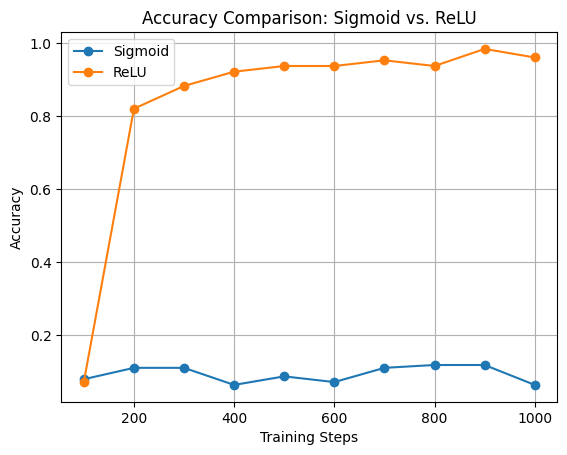

In [32]:
import matplotlib.pyplot as plt

# Accuracy values
accuracy_sigmoid = [0.078125, 0.109375, 0.109375, 0.0625, 0.0859375, 0.0703125, 0.109375, 0.1171875, 0.1171875, 0.0625]
accuracy_relu = [0.0703125, 0.8203125, 0.8828125, 0.921875, 0.9375, 0.9375, 0.953125, 0.9375, 0.984375, 0.9609375]

# List of training steps 
training_steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Plot the accuracy for Sigmoid
plt.plot(training_steps, accuracy_sigmoid, label='Sigmoid', marker='o')

# Plot the accuracy for ReLU
plt.plot(training_steps, accuracy_relu, label='ReLU', marker='o')

# Set plot labels and legend
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Sigmoid vs. ReLU')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

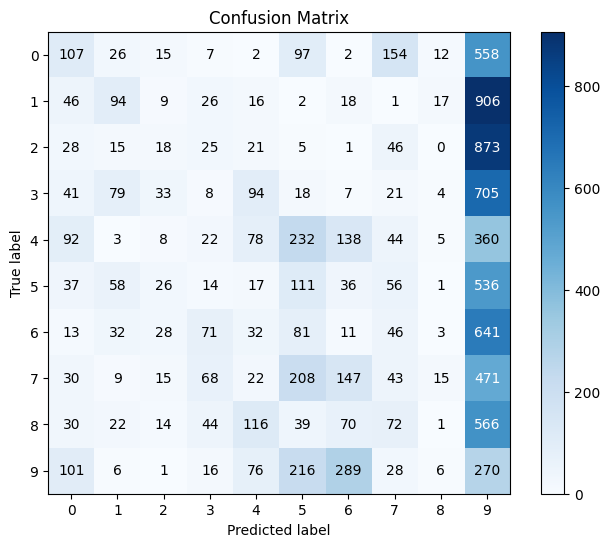

In [33]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    data.test_labels, 
    test_preds,
    figsize=(8,6))

#Increasing the learning rate, 2 hidden layer and relu activation function

In [34]:
train_steps = 1000
learning_rate = 0.5

# adding the weights connecting the input to the hidden layer
W1 = tf.Variable(tf.random.uniform([784, 50],minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b1 = tf.Variable(np.ones(50, dtype=np.float32))

# adding the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random.uniform([50, 10],minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b2 = tf.Variable(np.zeros(10, dtype=np.float32))

#start of training
for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()   
    with tf.GradientTape(persistent=True) as tape:
        
        hidden_out = tf.matmul(img_batch, W1)+ b1
        hidden_out = tf.nn.relu(hidden_out)
        logits = tf.matmul(hidden_out, W2) + b2        
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=lbl_batch))       
          
    grads2 = tape.gradient(xent, [W2, b2])
    grads1 = tape.gradient(xent, [W1, b1])
    
    W2.assign_sub(learning_rate * grads2[0])
    b2.assign_sub(learning_rate * grads2[1])    
    W1.assign_sub(learning_rate * grads1[0])
    b1.assign_sub(learning_rate * grads1[1])
    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

test_preds = tf.argmax(tf.matmul(data.test_data, W_output) + b_output, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels), tf.float32))
print(acc)

Loss: 2.4912683963775635 Accuracy: 0.1171875
Starting new epoch...
Loss: 0.4606742262840271 Accuracy: 0.8671875
Loss: 0.22672495245933533 Accuracy: 0.9296875
Loss: 0.25112295150756836 Accuracy: 0.9375
Loss: 0.1952621191740036 Accuracy: 0.9375
Loss: 0.14005684852600098 Accuracy: 0.9609375
Starting new epoch...
Loss: 0.1721973717212677 Accuracy: 0.9453125
Loss: 0.10781638324260712 Accuracy: 0.96875
Loss: 0.10005393624305725 Accuracy: 0.984375
Loss: 0.08800742030143738 Accuracy: 0.96875
tf.Tensor(0.0741, shape=(), dtype=float32)


In [35]:
h_layer=tf.matmul(data.test_data, W1) + b1
hidden_out = tf.nn.relu(h_layer)
test_preds = tf.argmax(tf.matmul(hidden_out,W2) + b2, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)

tf.Tensor(0.9615, shape=(), dtype=float32)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

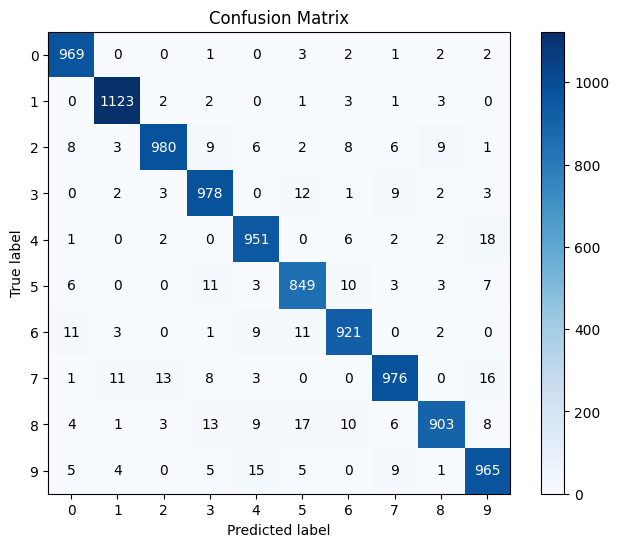

In [36]:
skplt.metrics.plot_confusion_matrix(
    data.test_labels, 
    test_preds,
    figsize=(8,6))

9615  instances classified correctly
385  instances classified incorrectly


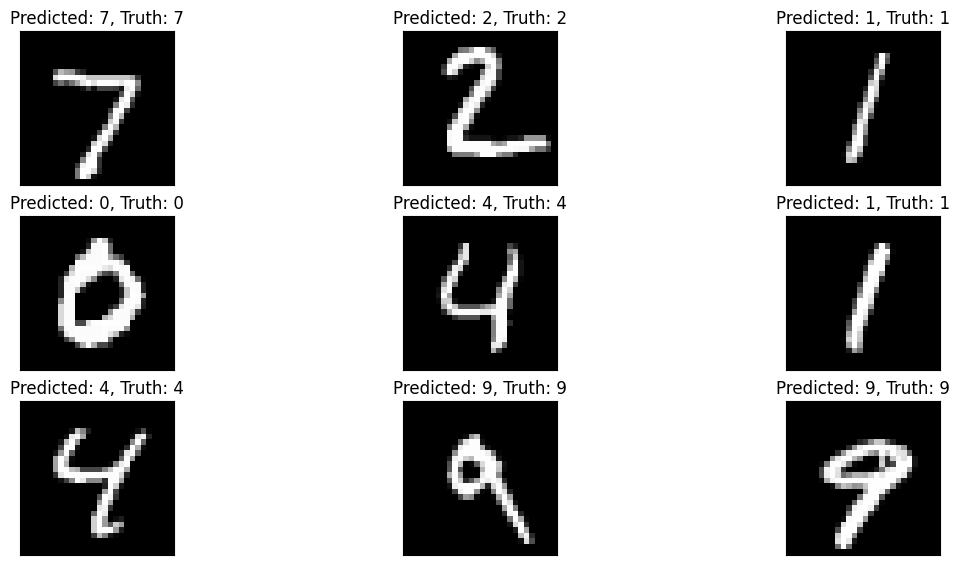

In [37]:
predicted_classes = test_preds

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == test_labels)[0]
incorrect_indices = np.nonzero(predicted_classes != test_labels)[0]

print(len(correct_indices)," instances classified correctly")
print(len(incorrect_indices)," instances classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (14,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(test_images[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        test_labels[correct]))
    plt.xticks([])
    plt.yticks([])

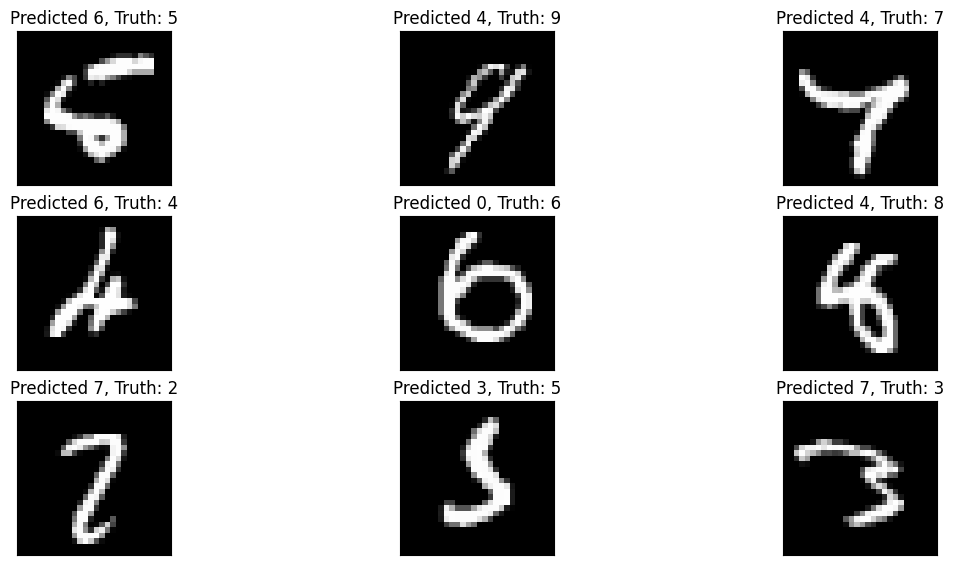

In [38]:
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(test_images[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       test_labels[incorrect]))
    plt.xticks([])
    plt.yticks([])

#Few takeaways
1. Increasing the training steps gives better accuracy results, but there is no significant difference.

2. Increasing the learning rate also gave us better accuracy results. 

3. Changing the weight initializations makes a lot of difference in the results. The accuracy significantly decreases if the weights are initialized to 0, and also if the initializations are farther from 0. 

4. Assigning same weights leads to problem of symmetry.

4. Modifying the hidden layer sizes or adding more hidden layers makes no significant differences to the accuracy.

#Fasion MNIST

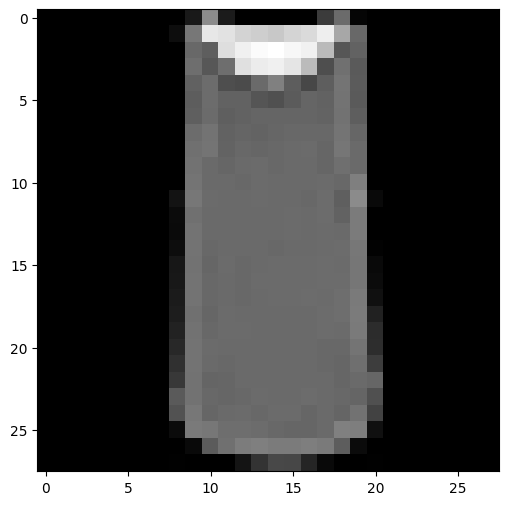

In [43]:
mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
plt.figure(figsize = (26,6))
plt.imshow(train_images[2], cmap="Greys_r")

In [53]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
print(train_images.reshape([-1, 784]).shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
(60000, 784)


In [64]:
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)
train_steps = 1000
learning_rate = 0.1

#Taking 2 hidden layer with 500 and 300 neurons.

# adding the weights connecting the input to the hidden layer 1
W1 = tf.Variable(tf.random.uniform([784, 500],minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b1 = tf.Variable(np.ones(500, dtype=np.float32))

# adding the weights connecting the hidden layer1 to the hidden layer 2
W2 = tf.Variable(tf.random.uniform([500, 300],minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b2 = tf.Variable(np.ones(300, dtype=np.float32))

# adding the weights connecting the hidden layer to the output layer
W3 = tf.Variable(tf.random.uniform([300, 10],minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32))
b3 = tf.Variable(np.zeros(10, dtype=np.float32))

for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()   
    with tf.GradientTape() as tape:
        
        hidden_out1 = tf.nn.relu(tf.matmul(img_batch, W1)+ b1)  #128*500
        hidden_out2 = tf.nn.relu(tf.matmul(hidden_out1, W2) + b2)  #128*300
        logits = tf.matmul(hidden_out2, W3) + b3    #128*10    
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=lbl_batch))       

    grads = tape.gradient(xent,[W1, b1, W2, b2, W3, b3])
    

    W3.assign_sub(learning_rate * grads[4])
    b3.assign_sub(learning_rate * grads[5])
    W2.assign_sub(learning_rate * grads[2])
    b2.assign_sub(learning_rate * grads[3])    
    W1.assign_sub(learning_rate * grads[0])
    b1.assign_sub(learning_rate * grads[1])
    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

Loss: 3.11824369430542 Accuracy: 0.109375
Loss: 0.7041899561882019 Accuracy: 0.7265625
Loss: 0.502612829208374 Accuracy: 0.8515625
Loss: 0.5527688264846802 Accuracy: 0.75
Loss: 0.5364359021186829 Accuracy: 0.765625
Starting new epoch...
Loss: 0.6768088936805725 Accuracy: 0.7421875
Loss: 0.3627150058746338 Accuracy: 0.8515625
Loss: 0.3435061275959015 Accuracy: 0.8828125
Loss: 0.47777917981147766 Accuracy: 0.8125
Loss: 0.43686068058013916 Accuracy: 0.828125
Starting new epoch...


In [58]:
print(img_batch.shape)
print(W1.shape)
tf.matmul(img_batch, W1)

(128, 784)
(784, 500)


<tf.Tensor: shape=(128, 500), dtype=float32, numpy=
array([[ 0.8432817 ,  0.4057758 ,  0.1278019 , ..., -1.1074287 ,
         0.55441976,  1.9327576 ],
       [ 0.7561424 ,  0.8297601 ,  0.40495014, ..., -0.5637902 ,
         0.3172246 ,  1.4490976 ],
       [ 0.57227606, -0.5659941 ,  0.00279483, ..., -0.57316947,
         0.47895005,  1.7185509 ],
       ...,
       [ 0.23773865,  0.4482363 ,  0.76104015, ..., -0.24079353,
         0.32118   ,  0.61599165],
       [ 0.88510966,  0.2751778 ,  0.04621243, ..., -0.61097103,
         0.7272952 , -0.58146   ],
       [ 0.546237  , -0.48720273,  0.22753945, ..., -0.34842545,
         0.10691541,  0.98819077]], dtype=float32)>

In [66]:
#Accuracy check on the Test set
hidden_out1 = tf.nn.relu(tf.matmul(data.test_data, W1) + b1)
hidden_out2 = tf.nn.relu(tf.matmul(hidden_out1, W2) + b2)
test_preds = tf.argmax(tf.matmul(hidden_out2,W3) + b3, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)

tf.Tensor(0.8404, shape=(), dtype=float32)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

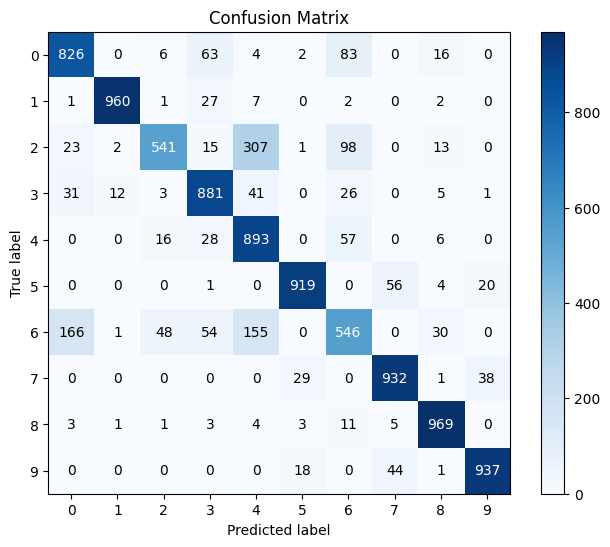

In [67]:
skplt.metrics.plot_confusion_matrix(
    test_labels, 
    test_preds,
    figsize=(8,6))

#some parts of the code such as creating layers, weight and bias updation can be replaced with higher level interfaces using APIs from Keras